# Grid Search

Use KL divergence to find the best-fit parameters for each model.

## Important Note on the Fitting
It's worth noting this fitting is stochasitc -- we don't have a closed form likelihood on which to evaluate the human behavior, and instead, we're matching the distribution of human data to the distribution of model data.  As a consequence, while the fitting procedure as a whole is probably fine, I don't know that I have a ton of confidence in the parameter values themselves.  By this I mean that if we were to run the grid search again with new samples, I think we would fine the same patterns of behavior and the same relative ordering of the models.  (I've actually done this a couple of times with slightly different constraints, which is why I'm confident in this).  That being said, I don't know if we would find the same parameters, and I don't know if a new sample of these paramters would produce consistent behavior. This problem is solvable (just run 10x more batches for the grid-search) but it's not particularly important for our purposes, so I've ignored it.

*The key takeaway from this is that if we want to make changes to the model for some reason, we would have to re-do the grid-search!*

What you don't want is to be in a situation where you're looking at effects that have evaporated for some reason under new simulations.  The fix to that is to re-run the grid search (maybe with a larger sample size) and check again.


## Load Libraries

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd

from glob import glob
import json

import re
import statsmodels.api as sm
import statsmodels.formula.api as smf

import os

sns.set_context('talk')

## Helper functions


### KL divergence

Here, we use the sample distribution of the model and the empirical distribution of the 
human subjects and assume their empirical mean and variances are the mean and variance of a normal approximation to the population distribution.  Then we use the KL divergence to fit the model

Let $p(x) = N(x; \mu_1, \sigma_1)$ be the human data and $q(x) = N(x; \mu_2, \sigma_2)$ be the model we are using to approximate the human data.  We are minimzing the KL with

$$KL(p||q) = -\int_x p(x) \ln \frac{q(x)}{p(x)}$$

which, with Gaussians is equal to 

$$KL(p||q) = \ln \frac{\sigma_2}{\sigma_1} + \frac{\sigma_1^2 + (\mu_1 - \mu_2)^2}{2\sigma^2_2} - \frac{1}{2}$$




In [2]:
def kl_pq(mu_1, mu_2, sd_1, sd_2):
    # p(x) = N(x; mu_1, sd_1)
    # q(x) = N(x; mu_2, sd_2)
    
    return np.log(sd_2) - np.log(sd_1) + \
        (sd_1 ** 2 + (mu_1 - mu_2)**2) / (2 * (sd_2**2) ) - 0.5

# Load data -- Trial by Trial

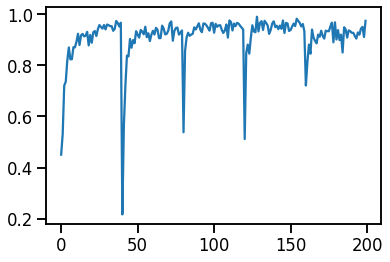

In [3]:
# human behavior
trial_by_trial = pd.read_csv('./data/BehDataTrialXTrial.csv', index_col=1)
trial_by_trial.columns = trial_by_trial.columns.str.lower()
plt.plot(trial_by_trial.loc[:,'blocked mean'])

### parse file string to uncover parameter set 

In [24]:
def parse_file_str(file_str):
  D = {}
  fsplit = file_str.split('_')
#   print(fsplit)
  D['cond'] = str(fsplit[-10])
  D['seed'] = int(fsplit[-1].split('.')[0])
  D['alfa'] = parse_alfa(fsplit[-4])
  D['lmbda'] = float(fsplit[-3])
  D['lr'] = float(fsplit[-8])
  D['nepochs'] = int(fsplit[-6])
  return D

def parse_alfa(alfa_str):
  asplit = alfa_str.split('-')
  if len(asplit)==3:
    alfa = -float(asplit[1])
  elif len(asplit)==2:
    alfa = float(asplit[0])
  else:
    print(asplit)
  return alfa

In [54]:
def create_gsdf(gs_name):
  """ create single long dataframe 
  with data from all models"""
  model_dfL = []
  fpathL = glob('gsdata/%s/t*'%gs_name)
  for idx,fpath in enumerate(fpathL):
    param_dict = parse_file_str(fpath)
    model_data = pd.read_csv(fpath)
    # populate model_dat with param_dict
    for name,val in param_dict.items():
      model_data.loc[:,name] = val
    model_data.loc[:,model_idx] = idx
    model_dfL.append(model_data)
  gsdf = pd.concat(model_dfL)
  return gsdf

# gsdf = create_gsdf('sem1')
# gsdf.to_csv('gsdata/sem1/gsdf-sem1')

In [55]:
gsdf = pd.read_csv('gsdata/sem1/gsdf-sem1')
gsdf

,Unnamed: 0,Unnamed: 0.1,t,e_hat,accuracy,pe,seed,condition,cond,alfa,lmbda,lr,nepochs
0,0,0,0,0,0.383845,0.732405,1,blocked,blocked,-16.0,32.0,0.01,4
1,1,1,1,0,0.159671,0.659243,1,blocked,blocked,-16.0,32.0,0.01,4
2,2,2,2,0,0.448376,0.525375,1,blocked,blocked,-16.0,32.0,0.01,4
3,3,3,3,0,0.533884,0.471617,1,blocked,blocked,-16.0,32.0,0.01,4
4,4,4,4,0,0.243571,0.563420,1,blocked,blocked,-16.0,32.0,0.01,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7809195,195,195,195,195,0.675595,1.018367,9,blocked,blocked,32.0,-2.0,0.01,32
7809196,196,196,196,196,0.498172,0.937761,9,blocked,blocked,32.0,-2.0,0.01,32
7809197,197,197,197,197,0.126725,1.001923,9,blocked,blocked,32.0,-2.0,0.01,32
7809198,198,198,198,198,0.300052,1.014361,9,blocked,blocked,32.0,-2.0,0.01,32



### compute error metrics 

In [ ]:
def get_KL_and_MSE(file):
  """ 
  returns error metrics (KL and MSE) for given parameter_set
  """
  # load model trial-by-trial data
  model_data = pd.read_csv(file)
  model_data.columns = model_data.columns.str.lower()
  # sum MSE and KL across conditions
  MSE = 0
  KL = 0
  model_grouped = model_data.groupby(['condition', 't'])
  for cond in ['blocked', 'interleaved']:
      # model mean and std 
      mu_model = model_grouped.mean().loc[cond]['accuracy'].values
      sd_model = model_grouped.std().loc[cond]['accuracy'].values
      # human mean and std
      mu_beh = trial_by_trial.loc[:, '{} mean'.format(cond)].values
      sd_beh = trial_by_trial.loc[:, '{} stddev'.format(cond)].values
      # add error over conditions
      MSE += np.mean((mu_beh - mu_model) ** 2)
      KL  += np.sum(kl_pq(mu_beh, mu_model, sd_beh, sd_model))
  return {
    'MSE':MSE,
    'KL':KL
  }


In [ ]:
""" 
make results_df: 
  dataframe with fitting data from all models 
"""

head_dir = './data/gridsearch_full1/'
trial_files = glob(head_dir + 'trial*csv')
files.sort()

L = []
for file in trial_files:
  err_dict = get_KL_and_MSE(file)
  param_dict = parse_file_str(file)
  L.append({**param_dict,**err_dict})
results_df = pd.pandas.DataFrame(L)

### NB Nick's code had a bug, so that he was using MSE instead of KL

In [ ]:
results_df.groupby('model_type')['MSE'].min()

In [ ]:
results_df.groupby('model_type')['KL'].min()

### get model with min error

In [ ]:
def get_min_err_model(model_type,eval_metric):
  """ returns trial-by-trial dataframe 
  with info from best fit model
  """
  min_err = results_df.groupby('model_type')[eval_metric].min()[model_type]
  _,lr,nep,alfa,lmbda,_,_ = results_df[results_df[eval_metric] == min_err].values[0]
  fpath = "trial_X_trial_%s-lr-%.3f-nepchs-%i-alpha-%.3f-lambda-%.3f.csv"%(
            model_type,lr,nep,alfa,lmbda)
  print(fpath)
  df = pd.read_csv(head_dir+'/'+fpath)
  return df


In [ ]:
model_df = get_min_err_model('LSTM','MSE')
model_df

In [ ]:
sns.relplot(data=model_df[model_df.Condition=='blocked'],
            x='t', y='Accuracy', kind='line', aspect=2, height=3)
plt.ylim(0.4,1)

# nick

In [ ]:
assert False

In [ ]:
#LSTM
model = 'LSTM'
tXt_Loss.loc[(tXt_Loss.model == model) & (tXt_Loss.KL == min_vals[model])]

In [ ]:
#SEM
model = 'SEM'
tXt_Loss.loc[(tXt_Loss.model == model) & (tXt_Loss.KL == min_vals[model])]

In [ ]:
#MLP
model = 'MLP'
tXt_Loss.loc[(tXt_Loss.model == model) & (tXt_Loss.KL == min_vals[model])]

In [ ]:
def get_data(model):
    theta = tXt_Loss.loc[(tXt_Loss.model == model) & (tXt_Loss.KL == min_vals[model])]
    lr, n_epochs, logalpha, loglamda = \
        theta.loc[:, 'lr n_epochs logalpha loglamda'.split()].values[0]
    
    model_name = ['VanillaLSTM', 'MLP'][model == 'MLP']
    no_split_tag = ['_nosplit', ''][model == 'SEM']
    
    args = [lr, int(n_epochs), float(logalpha), float(loglamda),no_split_tag]
#     hdir = 'data/'
    file = '{}trial_X_trial_{}_nhiddenNone_e1e-05_lr'.format(path, model_name)
    file += '{}_n{}_d0.0_logalfa_{}_loglmda_{}_{}_online.csv'.format(*args)
#     return file
    return pd.read_csv(file)


In [ ]:
get_data('SEM')

In [ ]:
def plot_acc_by_time(model, condition):
    df = get_data(model)
    sns.relplot(data=df[df.Condition==condition],
            x='t', y='Accuracy', kind='line', aspect=2, height=3)
    plt.title(condition)
    plt.xlabel('Story')
    plt.ylim(0, 1.0)
    plt.xlim(0, 200)
    return plt.gcf()

def plot_pe_by_time(model, condition):
    df = get_data(model)
    sns.relplot(data=df[df.Condition==condition],
            x='t', y='pe', kind='line', aspect=2, height=3)
    plt.title(condition)
    plt.xlabel('Story')
    plt.ylabel('Prediction Error')
    plt.xlim(0, 200)
    plt.ylim(0, 1)
    return plt.gcf()

In [ ]:
df = get_data("SEM")
sns.relplot(data=df, hue='Condition',
        x='t', y='Accuracy', kind='line', aspect=2, height=3)
plt.title('SEM')

In [ ]:
df = get_data("LSTM")
sns.relplot(data=df, hue='Condition',
        x='t', y='Accuracy', kind='line', aspect=2, height=3)
plt.title('LSTM')

In [ ]:
df = get_data("MLP")
sns.relplot(data=df, hue='Condition',
        x='t', y='Accuracy', kind='line', aspect=2, height=3)
plt.title('MLP')

## Model fitting: Blocked/Interleaved Only

In [ ]:
# Load files one at a time
tXt_Loss_BIonly = []
sim = 0
files = glob(path + 'trial*csv')

def get_error(file):

    model_data = pd.read_csv(file)
    model_grouped = model_data.groupby(['Condition', 't'])

    
    MSE = 0
    KL = 0

    for cond in ['Blocked', 'Interleaved']:
        mu_model = model_grouped.mean().loc[cond]['Accuracy'].values
        sd_model = model_grouped.std().loc[cond]['Accuracy'].values

        mu_beh = trial_by_trial.loc[:, '{} Mean'.format(cond)].values
        sd_beh = trial_by_trial.loc[:, '{} StdDev'.format(cond)].values

        MSE += np.mean((mu_beh - mu_model) ** 2)
        KL  += np.sum(kl_pq(mu_beh, mu_model, sd_beh, sd_model))

    return {
            'KL': MSE,
            'MSE': KL,
        }


for file in tqdm(files):
    
    idx = file.find('nhidden') + 7
    n_hidden = pull_from_start(file, idx)
    if n_hidden == 'None':
        n_hidden = 10
    else:
        n_hidden = int(pull_from_start(file, idx))
    
    # learning rate -- this we can't find a reliable end point beyond 
    # "_" charaecter
    idx = file.find('_lr') + 3
    lr = float(pull_from_start(file, idx))

    # n_epochs
    idx = file[idx:].find('_n') + idx + 2
    n = int(pull_from_start(file, idx))

    # dropout
    idx = file[idx:].find('_d') + idx + 2
    d = float(pull_from_start(file, idx))

    # loglmda
    idx = file.find('_loglmda') + 9
    loglamda =float(pull_from_start(file, idx))

    # logalpha
    idx = file.find('_logalfa') + 9
    idx2 = file.find('_loglmda')
    logalpha = float(file[idx:idx2])       
    
    # epsilon
    idx = file.find('_e') + 2
    epsilon = float(pull_from_start(file, idx))

    _tXt = get_error(file)
    _tXt['lr'] = lr
    _tXt['n_epochs'] = n
    _tXt['dropout'] = d
    _tXt['epsilon'] = epsilon
    _tXt['loglamda'] = loglamda
    _tXt['logalpha'] = logalpha
    _tXt['sim'] = sim
    _tXt['n_hidden'] = n_hidden
    _tXt['model'] = get_model(file)

    tXt_Loss_BIonly.append(_tXt)
    sim += 1
    
#     break
tXt_Loss_BIonly = pd.DataFrame(tXt_Loss_BIonly)
tXt_Loss_BIonly.index = range(len(tXt_Loss_BIonly))




In [ ]:
min_vals_BIonly = tXt_Loss_BIonly.groupby('model')['MSE'].min()
min_vals_BIonly

In [ ]:

def get_data(model, fits_df, metric='KL'):
    
    min_vals = fits_df.groupby('model')[metric].min()
    theta = fits_df.loc[(fits_df.model == model) & (fits_df[metric] == min_vals[model])]
    lr, n_epochs, logalpha, loglamda = \
        theta.loc[:, 'lr n_epochs logalpha loglamda'.split()].values[0]
    print(lr, n_epochs, logalpha, loglamda)
    
    model_name = ['VanillaLSTM', 'MLP'][model == 'MLP']
    no_split_tag = ['_nosplit', ''][model == 'SEM']
    
    args = [lr, int(n_epochs), float(logalpha), float(loglamda),no_split_tag]
    
    file = '{}trial_X_trial_{}_nhiddenNone_e1e-05_lr'.format(path, model_name)
    file += '{}_n{}_d0.0_logalfa_{}_loglmda_{}_{}_online_instructed.csv'.format(*args)

    return pd.read_csv(file)



In [ ]:
df = get_data("MLP", tXt_Loss_BIonly)
sns.relplot(data=df, hue='Condition',
        x='t', y='Accuracy', kind='line', aspect=2, height=3)
plt.title('MLP')

In [ ]:
df = get_data("SEM", tXt_Loss_BIonly)
sns.relplot(data=df, hue='Condition',
        x='t', y='Accuracy', kind='line', aspect=2, height=3)
plt.title('SEM')

In [ ]:
df = get_data("LSTM", tXt_Loss_BIonly)
sns.relplot(data=df, hue='Condition',
        x='t', y='Accuracy', kind='line', aspect=2, height=3)
plt.title('LSTM')